On perlmutter: use kernel pytorch-1.13.1

In [ ]:
!pip install nflows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from numba import cuda 

from helpers.make_flow import *
from helpers.train_flow import *

seed = 8

In [2]:
# computing
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


In [3]:
# load in the data

SB_data = np.load(f"processed_data/od_SB.npy")

print(f"SB data has shape {SB_data.shape}.")

SB data has shape (71, 9).


In [4]:
# train val test split
from sklearn.model_selection import train_test_split

SB_data_train, SB_data_val = train_test_split(SB_data, test_size=0.2, random_state=42)

print(f"SB train data has shape {SB_data_train.shape}.")
print(f"SB val data has shape {SB_data_val.shape}.")

SB train data has shape (56, 9).
SB val data has shape (15, 9).


In [ ]:
# Create the flow

# This will be the upper subdirectory in saved_models/

num_layers = 1
num_hidden_features = 128
num_blocks = 15
flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_blocks}hidden_{num_blocks}blocks_{seed}seed"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")
os.makedirs(flow_training_dir, exist_ok=True)

hyperparameters_dict = {"n_epochs":100,
                          "batch_size": 128,
                          "lr": 0.0001,
                          "weight_decay": 0.0001}


test_flow = make_masked_AR_flow(SB_data_train.shape[1]-1, num_layers, num_hidden_features, num_blocks)

epochs, losses, losses_val, best_epoch = train_flow(test_flow, hyperparameters_dict, device, SB_data_train, SB_data_val, flow_training_dir, seed = seed)


Training flow for 100 epochs ...



  4%|▍         | 4/100 [00:02<01:11,  1.33it/s]

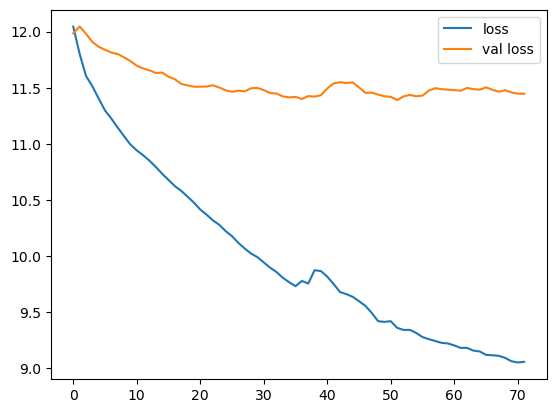

-1


In [6]:
plt.figure()
plt.plot(epochs, losses, label = "loss")
plt.plot(epochs, losses_val, label = "val loss")
plt.legend()
plt.show()

print(best_epoch)